# Setup


In [265]:
# Clone original project for datasets
# Can use any movie lens dataset however to replicate the original
# implementation and for comparison of results will use their 100k
!git clone https://github.com/usydnlp/Glocal_K.git

fatal: destination path 'Glocal_K' already exists and is not an empty directory.


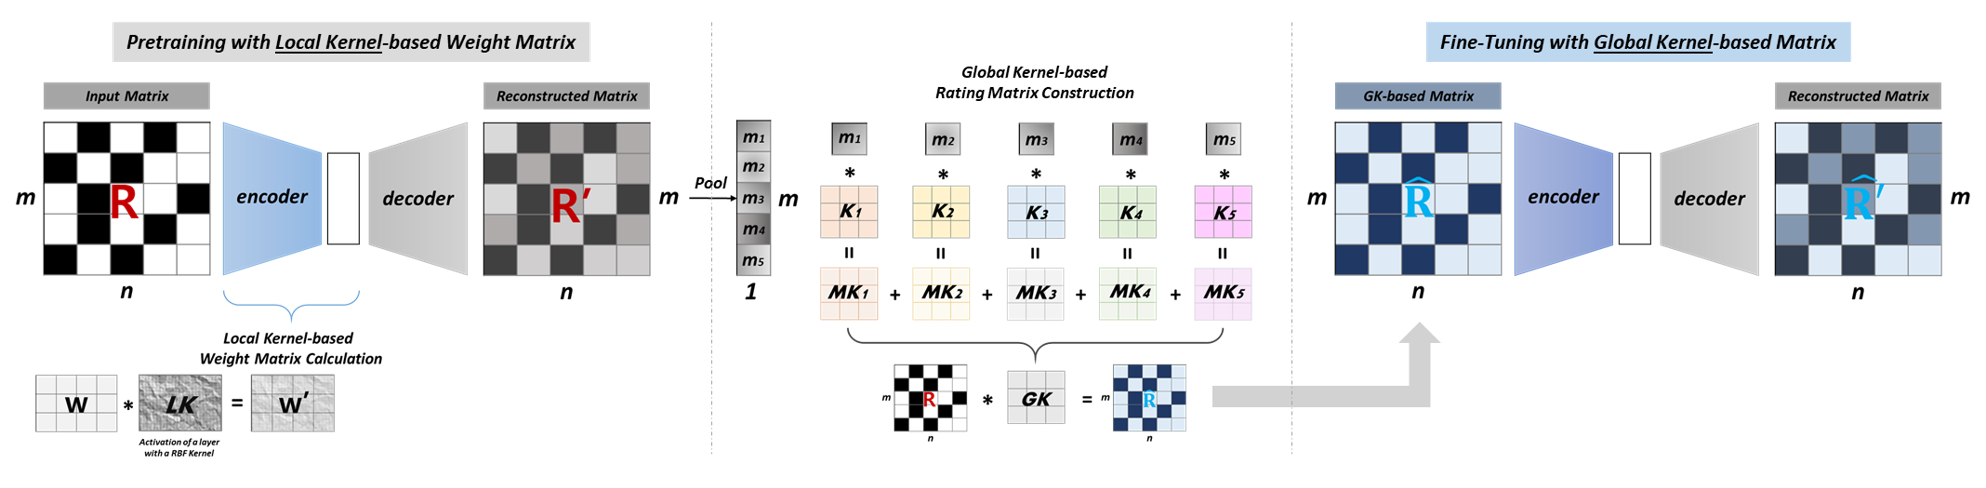

https://github.com/usydnlp/Glocal_K


In [266]:
# Library imports
from time import time
import numpy as np

# Original project uses Tensorflow, however I am writing this implementation in Pytorch as I am more
# familiar with it with the Labs and coursework
import torch
import torch.nn as nn

In [267]:
# Set device for Pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Loading Function


In [268]:
# Load data from the original project
def load_data(path="./", delimiter="\t"):
    train = np.loadtxt(
        path + "movielens_100k_u1.base", skiprows=0, delimiter=delimiter
    ).astype("int32")
    test = np.loadtxt(
        path + "movielens_100k_u1.test", skiprows=0, delimiter=delimiter
    ).astype("int32")
    total = np.concatenate((train, test), axis=0)

    n_u = np.unique(total[:, 0]).size  # num of users
    n_m = np.unique(total[:, 1]).size  # num of movies
    n_train = train.shape[0]  # num of training ratings
    n_test = test.shape[0]  # num of test ratings

    # Rating matrix for training and test data
    train_r = np.zeros((n_m, n_u), dtype="float32")
    test_r = np.zeros((n_m, n_u), dtype="float32")

    # Fill in the rating matrices, notice that the indices are shifted by
    # 1 since the original data starts from index 1 and not 0
    for i in range(n_train):
        train_r[train[i, 1] - 1, train[i, 0] - 1] = train[i, 2]

    for i in range(n_test):
        test_r[test[i, 1] - 1, test[i, 0] - 1] = test[i, 2]

    # Boolean mask for training and test data, 1 if rating exists, 0 if not
    train_m = np.greater(train_r, 1e-12).astype("float32")
    test_m = np.greater(test_r, 1e-12).astype("float32")

    print("Data loaded\n")
    print("Number of Users: {}".format(n_u))
    print("Number of Movies: {}".format(n_m))
    print("Number of Training Ratings: {}".format(n_train))
    print("Number of Test Ratings: {}".format(n_test))

    return n_m, n_u, train_r, train_m, test_r, test_m

# Load Data


In [269]:
data_path = "Glocal_K/data/MovieLens_100K/"

try:
    n_m, n_u, train_r, train_m, test_r, test_m = load_data(
        path=data_path, delimiter="\t"
    )
except Exception as e:
    print("Error whlie loading data")
    print(e)

Data loaded

Number of Users: 943
Number of Movies: 1682
Number of Training Ratings: 80000
Number of Test Ratings: 20000


# Hyperparameters


In [270]:
# Common hyperparameter settings, most of these are the same as the original implementation,
# and pytorch specific ones are from https://github.com/fleanend/TorchGlocalK

# Number of hidden units
n_hid = 500
# Size of latent factors
n_dim = 5
# Number of hidden layers
n_layers = 1
# Size of global kernel
gk_size = 3

# Max number of iterations for pretraining and finetuning
iter_p = 5 
iter_f = 5

# Regularisation of the final matrix
lambda_l2 = 20.
# Regularisation of the global kernel
lambda_s = 0.006
# Max number of epochs for pretraining
max_epoch_p = 60
# Max number of epochs for finetuning
max_epoch_f = 120
# Scaling weight factor for dot product in the kernel
dot_scale = 1

# Learning rate
lr_p = 1.
lr_f = 1.

# Network Functions


In [271]:
# Computes local kernel between two tensors, u & v
def local_kernel(u, v):
    # Measures similarity based on Euclidean distance, smaller distance = higher value
    distance = torch.norm(u - v, p=2, dim=2)
    # Hat matrix, clamps values to be between 0 and 1-distance^2
    hat = torch.clamp(1.0 - distance**2, min=0.0)

    return hat

In [272]:
# Kernal Layer and Network, implementation based on https://github.com/fleanend/TorchGlocalK/blob/main/Original_Glocal_K.ipynb and https://pytorch.org/docs/stable/generated/nn.Module.html


# Single layer of network
class KernelLayer(nn.Module):
    # Initializes layer
    # n_in = number of input nodes,
    # n_hid = number of hidden nodes,
    # n_dim = size of latent factors,
    # lambda_s = regularisation of global kernel,
    # lambda_l2 = regularisation of final matrix,
    # activation = activation function
    def __init__(self, n_in, n_hid, n_dim, lambda_s, lambda_l2, activation=nn.Sigmoid()):
        super().__init__()

        # Weight matrix
        self.W = nn.Parameter(torch.randn(n_in, n_hid))
        # Vectors
        self.u = nn.Parameter(torch.randn(n_in, 1, n_dim))
        self.v = nn.Parameter(torch.randn(1, n_hid, n_dim))
        # Bias
        self.b = nn.Parameter(torch.randn(n_hid))
        # Lambda functions
        self.lambda_s = lambda_s
        self.lambda_l2 = lambda_l2

        # Initializes weights and biases
        nn.init.xavier_uniform_(self.W, gain=nn.init.calculate_gain("relu"))
        nn.init.xavier_uniform_(self.u, gain=nn.init.calculate_gain("relu"))
        nn.init.xavier_uniform_(self.v, gain=nn.init.calculate_gain("relu"))
        nn.init.zeros_(self.b)
        self.activation = activation

    # Forward pass
    def forward(self, x):
        # Computes local kernel between u and v
        w_hat = local_kernel(self.u, self.v)

        # Sparse Reg. MSE between w_hat and 0, measures sparsity
        sparse_reg = nn.functional.mse_loss(w_hat, torch.zeros_like(w_hat))
        # Scales Sparse Reg. by lambda, used later as regularization term for the layer
        sparse_reg_term = self.lambda_s * sparse_reg

        # L2 Reg. sum of the squares of all the weights in the weight matrix, MSE like above
        l2_reg = nn.functional.mse_loss(self.W, torch.zeros_like(self.W))
        # Scales L2 Reg. by lambda, used later as regularization term for the layer
        l2_reg_term = self.lambda_l2 * l2_reg

        # Weighted matrix multiplication = (tensor x * weight) * local kernel
        W_eff = self.W * w_hat
        # Matrix multiplication + bias, Output layer, ((tensor x * weight) * local kernel) + bias
        y = torch.matmul(x, W_eff) + self.b
        # Sigmoid activation function on output
        y = self.activation(y)

        return y, sparse_reg_term + l2_reg_term

In [273]:
# Network, contains multiple kernal layers
class KernelNet(nn.Module):
    # Initializes network
    # n_u = number of users,
    # n_hid = number of hidden nodes,
    # n_dim = size of latent factors,
    # n_layers = number of hidden layers,
    # lambda_s = regularisation of global kernel,
    # lambda_l2 = regularisation of final matrix
    # activation = activation function
    def __init__(self, n_u, n_hid, n_dim, n_layers, lambda_s, lambda_l2):
        super().__init__()

        # List of layers
        layers = []
        # Adds layers to list, first layer has n_u input nodes, last layer has n_u output nodes
        for i in range(n_layers):
            # First layer
            if i == 0:
                layers.append(KernelLayer(n_u, n_hid, n_dim, lambda_s, lambda_l2))
            else:
                layers.append(KernelLayer(n_hid, n_hid, n_dim, lambda_s, lambda_l2))
        # Last layer, nn.Identity() used to not apply activation function to output
        layers.append(
            KernelLayer(n_hid, n_u, n_dim, lambda_s, lambda_l2, activation=nn.Identity())
        )
        # Adds layers to network as a module list
        self.layers = nn.ModuleList(layers)
        # Dropout layer, used to prevent overfitting,
        # randomly sets values in the input tensor to zero
        self.dropout = nn.Dropout(0.5)

    # Forward pass
    def forward(self, x):
        total_reg = None
        # Applies dropout to all layers but the last
        for i, layer in enumerate(self.layers):
            x, reg = layer(x)
            if i < len(self.layers) - 1:
                x = self.dropout(x)
            if total_reg is None:
                total_reg = reg
            else:
                total_reg += reg
        return x, total_reg

In [274]:
class CompleteNet(nn.Module):
    def __init__(
        self,
        kernel_net,
        n_u,
        n_m,
        n_hid,
        n_dim,
        n_layers,
        lambda_s,
        lambda_l2,
        gk_size,
        dot_scale,
    ):
        super().__init__()
        self.gk_size = gk_size
        self.dot_scale = dot_scale
        self.local_kernel_net = kernel_net
        self.conv_kernel = nn.Parameter(torch.randn(n_m, gk_size**2) * 0.1)
        nn.init.xavier_uniform_(
            self.conv_kernel, gain=nn.init.calculate_gain("relu")
        )

    # Global kernel
    def global_kernel(self, input, gk_size, dot_scale):
        # Average pooling, reduces the size of the input
        avg_pooling = torch.mean(input, dim=1).view(1, -1)

        # Matrix multiplication, dot product between the input and the convolution kernel, scales the result
        gk = (torch.matmul(avg_pooling, self.conv_kernel) * dot_scale).view(1, 1, gk_size, gk_size)

        return gk

    # Global convolution
    def global_conv(self, input, W):
        # Adds a dimension to the input tensor, to be able to use convolution
        input = input.unsqueeze(0).unsqueeze(0)
        # Applies convolution to the input
        conv2d = nn.LeakyReLU()(nn.functional.conv2d(input, W, stride=1, padding=1))
        return conv2d.squeeze(0).squeeze(0)

    # Forward pass
    def forward(self, x, x_local):
        gk = self.global_kernel(x_local, self.gk_size, self.dot_scale)
        x = self.global_conv(x, gk)
        # Applies local kernel network
        x, global_reg_loss = self.local_kernel_net(x)
        return x, global_reg_loss

In [275]:
# Loss function, combines the loss of the local kernel network and the global convolution
class Loss(nn.Module):
    # Initializes loss function
    def forward(self, pred_p, reg_loss, train_m, train_r):
      # L2 loss
      diff = train_m * (train_r - pred_p)
      # Squared error
      sqE = nn.functional.mse_loss(diff, torch.zeros_like(diff))
      # Total loss
      loss_p = sqE + reg_loss
      return loss_p

# Evaluation Functions

In [276]:
def dcg_k(score_label, k):
    dcg, i = 0., 0
    for s in score_label:
        if i < k:
            dcg += (2**s[1]-1) / np.log2(2+i)
            i += 1
    return dcg

In [277]:
def ndcg_k(y_hat, y, k):
    score_label = np.stack([y_hat, y], axis=1).tolist()
    score_label = sorted(score_label, key=lambda d:d[0], reverse=True)
    score_label_ = sorted(score_label, key=lambda d:d[1], reverse=True)
    norm, i = 0., 0
    for s in score_label_:
        if i < k:
            norm += (2**s[1]-1) / np.log2(2+i)
            i += 1
    dcg = dcg_k(score_label, k)
    return dcg / norm

In [278]:
def call_ndcg(y_hat, y):
    ndcg_sum, num = 0, 0
    y_hat, y = y_hat.T, y.T
    n_users = y.shape[0]

    for i in range(n_users):
        y_hat_i = y_hat[i][np.where(y[i])]
        y_i = y[i][np.where(y[i])]

        if y_i.shape[0] < 2:
            continue

        ndcg_sum += ndcg_k(y_hat_i, y_i, y_i.shape[0])  # user-wise calculation
        num += 1

    return ndcg_sum / num

# Create Network


In [279]:
# Pretrain function, trains the local kernel network
model = KernelNet(n_u, n_hid, n_dim, n_layers, lambda_s, lambda_l2).double().to(device)

# Optimizer, fine tuning of the network
complete_model = CompleteNet(model, n_u, n_m, n_hid, n_dim, n_layers, lambda_s, lambda_l2, gk_size, dot_scale).double().to(device)

# Pre-train Network

In [280]:
best_rmse_ep, best_mae_ep, best_ndcg_ep = 0, 0, 0
best_rmse, best_mae, best_ndcg = float("inf"), float("inf"), 0

time_cumulative = 0
tic = time()

# Pre-Training
optimizer = torch.optim.LBFGS(complete_model.local_kernel_net.parameters(), history_size=10, max_iter=iter_p, lr=lr_p)

def closure():
  optimizer.zero_grad(set_to_none=True)
  x = torch.Tensor(train_r).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.local_kernel_net.train()
  pred, reg = complete_model.local_kernel_net(x)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

for i in range(max_epoch_p):
  optimizer.step(closure)
  complete_model.local_kernel_net.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = model(torch.Tensor(train_r).double().to(device))
  
  pre = pre.float().cpu().detach().numpy()
  
  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)

  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)
  
  print('.-^-._' * 12)
  print('PRE-TRAINING')
  print('Epoch:', i, 'test rmse:', test_rmse, 'train rmse:', train_rmse)
  print('Time:', t, 'seconds')
  print('Time cumulative:', time_cumulative, 'seconds')
  print('.-^-._' * 12)

.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 0 test rmse: 1.6017118 train rmse: 1.4123279
Time: 0.27561235427856445 seconds
Time cumulative: 0.27561235427856445 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 1 test rmse: 1.082109 train rmse: 0.9904439
Time: 0.5903191566467285 seconds
Time cumulative: 0.865931510925293 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 2 test rmse: 1.0671368 train rmse: 0.96161014
Time: 0.8960247039794922 seconds
Time cumulative: 1.7619562149047852 seconds
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._.-^-._
PRE-TRAINING
Epoch: 3 test rmse: 1.0180787 train rmse: 0.91195

# Fine Tune Network

In [281]:
train_r_local = np.clip(pre, 1., 5.)

optimizer = torch.optim.LBFGS(complete_model.parameters(), history_size=10, max_iter=iter_f, lr=lr_f)

def closure():
  optimizer.zero_grad(set_to_none=True)
  x = torch.Tensor(train_r).double().to(device)
  x_local = torch.Tensor(train_r_local).double().to(device)
  m = torch.Tensor(train_m).double().to(device)
  complete_model.train()
  pred, reg = complete_model(x, x_local)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

for i in range(max_epoch_f):
  optimizer.step(closure)
  complete_model.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = complete_model(torch.Tensor(train_r).double().to(device), torch.Tensor(train_r_local).double().to(device))
  
  pre = pre.float().cpu().detach().numpy()

  error = (test_m * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_m.sum()  # test error
  test_rmse = np.sqrt(error)

  error_train = (train_m * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_m.sum()  # train error
  train_rmse = np.sqrt(error_train)

  test_mae = (test_m * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_m.sum()
  train_mae = (train_m * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_m.sum()

  test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
  train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

  if test_rmse < best_rmse:
      best_rmse = test_rmse
      best_rmse_ep = i+1

  if test_mae < best_mae:
      best_mae = test_mae
      best_mae_ep = i+1

  if best_ndcg < test_ndcg:
      best_ndcg = test_ndcg
      best_ndcg_ep = i+1

  print('-=-=-=-=-=-=' * 12)
  print('Epoch:', i+1, 'test rmse:', test_rmse, 'test mae:', test_mae, 'test ndcg:', test_ndcg)
  print('Epoch:', i+1, 'train rmse:', train_rmse, 'train mae:', train_mae, 'train ndcg:', train_ndcg)
  print('Time:', t, 'seconds','Time cumulative:', time_cumulative, 'seconds')

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Epoch: 1 test rmse: 0.9815988 test mae: 0.7569548 test ndcg: 0.8897279653631146
Epoch: 1 train rmse: 0.85126 train mae: 0.6372601 train ndcg: 0.933874303367264
Time: 24.643593072891235 seconds Time cumulative: 620.1456229686737 seconds
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Epoch: 2 test rmse: 0.95582795 test mae: 0.7495811 test ndcg: 0.8918294952781275
Epoch: 2 train rmse: 0.76719743 train mae: 0.5984592 train ndcg: 0.9389652551267376
Time: 31.552492380142212 seconds Time cumulative: 651.6981153488159 seconds
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Epoch: 3 test rmse: 0.94011146 test mae: 0.7362665 test ndcg: 0.8967598090774024
Epoch: 

# Results

In [282]:
print('n_layers', n_layers)
print('learrning rates', lr_p, lr_f)
print('Epoch:', best_rmse_ep, ' best rmse:', best_rmse)
print('Epoch:', best_mae_ep, ' best mae:', best_mae)
print('Epoch:', best_ndcg_ep, ' best ndcg:', best_ndcg)

n_layers 1
learrning rates 1.0 1.0
Epoch: 17  best rmse: 0.89555395
Epoch: 17  best mae: 0.7030457
Epoch: 19  best ndcg: 0.9065868195613063
